In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Fetching data

In [2]:
from google.colab import drive

drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/FER2013/fer2013.csv')

# data = pd.read_csv('../../datasets/FER2013/fer2013.csv')

Mounted at /content/drive


In [3]:
def show_image(im_nb):
    pixels = data['pixels'].iloc[im_nb]
    label = data['emotion'].iloc[im_nb]
    image_array = np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48)

    cv2.imshow('Image', image_array)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(label)

In [4]:
# show_image(2)

| Index | Émotion   |
|-------|-----------|
| 0     | Angry     |
| 1     | Disgust   |
| 2     | Fear      |
| 3     | Happy     |
| 4     | Sad       |
| 5     | Surprise  |
| 6     | Neutral   |


In [5]:
def preprocess_images(data):
    images = []
    labels = data['emotion'].values

    for pixel_sequence in data['pixels']:
        single_image = np.fromstring(pixel_sequence, dtype=int, sep=' ')
        single_image = single_image.reshape(48, 48)
        images.append(single_image)

    images = np.array(images, dtype='float32')
    images = np.expand_dims(images, -1)  # Additional dimension for channels
    images /= 255.0  # Standardization (value between 0 and 1)

    return images, labels

In [6]:
images, labels = preprocess_images(data)
print(f"\nNumber of images in dataset: {len(images)}")


Number of images in dataset: 35887


## Class distributions

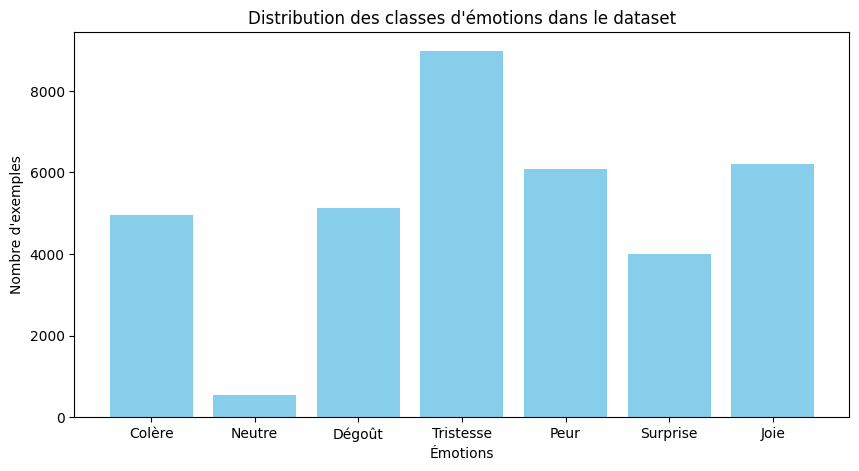

In [7]:
label_counts = Counter(labels)

emotions, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 5))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes d\'émotions dans le dataset')
plt.xticks(emotions, ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])
plt.show()

### Undersampling

In [8]:
def undersample_data(images, labels):
    labels = np.array(labels)

    min_class_size = np.min([sum(labels == i) for i in np.unique(labels)]) # Minority class

    undersampled_images = []
    undersampled_labels = []

    for label in np.unique(labels):

        class_images = images[labels == label]
        class_labels = labels[labels == label]

        class_images_undersampled, class_labels_undersampled = resample(class_images, class_labels,
                                                                        replace=False,
                                                                        n_samples=min_class_size,
                                                                        random_state=42)

        undersampled_images.extend(class_images_undersampled)
        undersampled_labels.extend(class_labels_undersampled)

    return np.array(undersampled_images), np.array(undersampled_labels)

In [9]:
images_resample, labels_resample = undersample_data(images, labels)
print(f"\nNumber of images in dataset after undersampling: {len(images_resample)}")


Number of images in dataset after undersampling: 3829


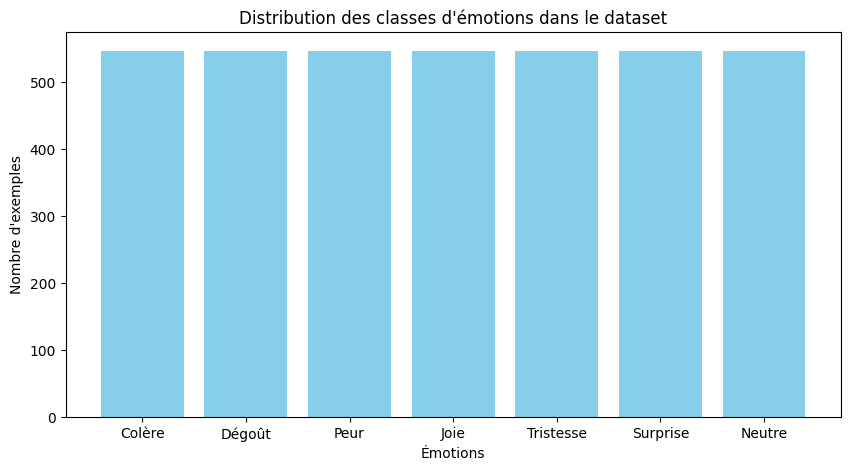

In [10]:
label_counts = Counter(labels_resample)

emotions, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 5))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes d\'émotions dans le dataset')
plt.xticks(emotions, ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])
plt.show()

In [11]:
print(f"\nReducing dataset size after undersampling : {len(images)/len(images_resample)*100:.2f}%")


Reducing dataset size after undersampling : 937.24%


### SMOTE

Splitting the dataset before applying SMOTE to avoid compromising the integrity of the test set.

In [12]:
images1D = images.reshape(images.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(images1D, labels, test_size=0.25, random_state=42)

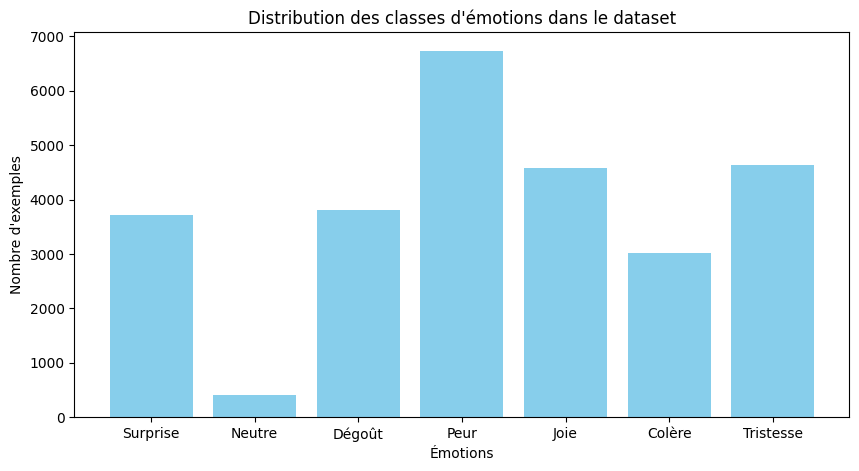

In [13]:
label_counts = Counter(y_train)

emotions, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 5))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes d\'émotions dans le dataset')
plt.xticks(emotions, ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])
plt.show()

In [14]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

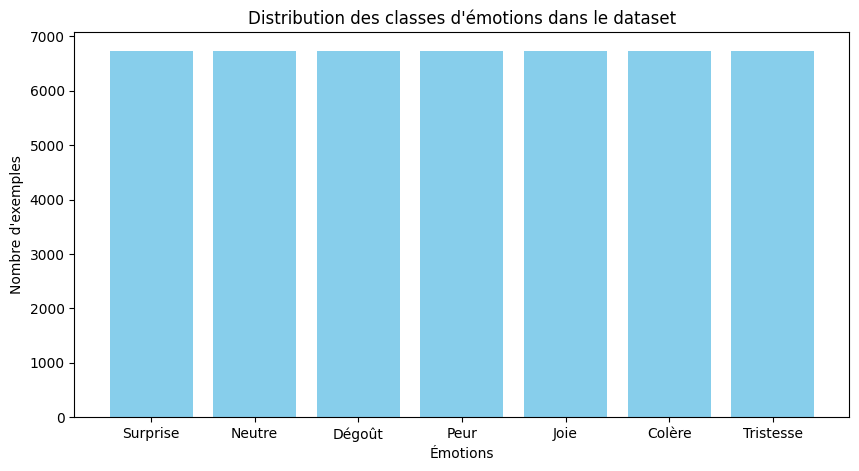

In [15]:
label_counts = Counter(y_train_sm)

emotions, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 5))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes d\'émotions dans le dataset')
plt.xticks(emotions, ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])
plt.show()

## Edge detection (HOG)

In [41]:
img = X_train_sm[6].reshape(48, 48)

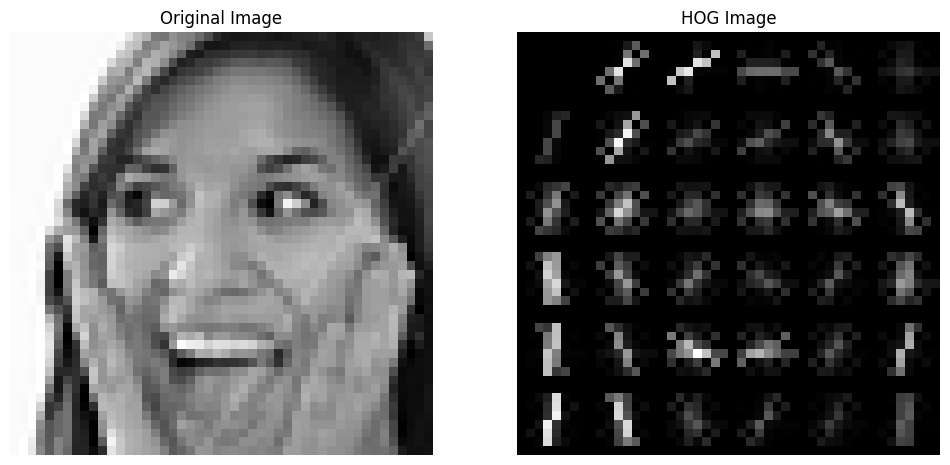

In [28]:
from skimage.feature import hog
from skimage import exposure

fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), block_norm='L1', visualize=True, channel_axis=None)


hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.show()



## CNN (test)

In [42]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal

img = np.expand_dims(img, axis=-1)  # Ajoute une dimension de canal -> (48, 48, 1)
img = np.expand_dims(img, axis=0)

# Définir l'entrée du modèle
input_img = Input(shape=(48, 48, 1))

# Ajouter les couches convolutives et de pooling
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal())(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)

# Créer le modèle complet
model = Model(inputs=input_img, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy')

model.predict(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[[[0.        , 0.        , 0.        , ..., 0.07877704,
          0.8650276 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.06820603,
          0.86416423, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.11409645,
          0.8723434 , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.01920291,
          0.05317091, 0.03987568],
         [0.        , 0.        , 0.        , ..., 0.01860306,
          0.10902249, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.04831557,
          0.05608441, 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.07941017,
          0.8653954 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.09857778,
          0.8677461 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.19139075,
          0.9034316 , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.08577076,
          0.08535548, 0.0

In [43]:
# Obtenir la sortie de la première couche Conv2D
layer_outputs = [model.layers[3].output]  # Index 1 car c'est la première couche Conv2D après l'Input

# Créer un modèle pour obtenir les activations
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Obtenir les feature maps
first_layer_activation = activation_model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


### Display features map

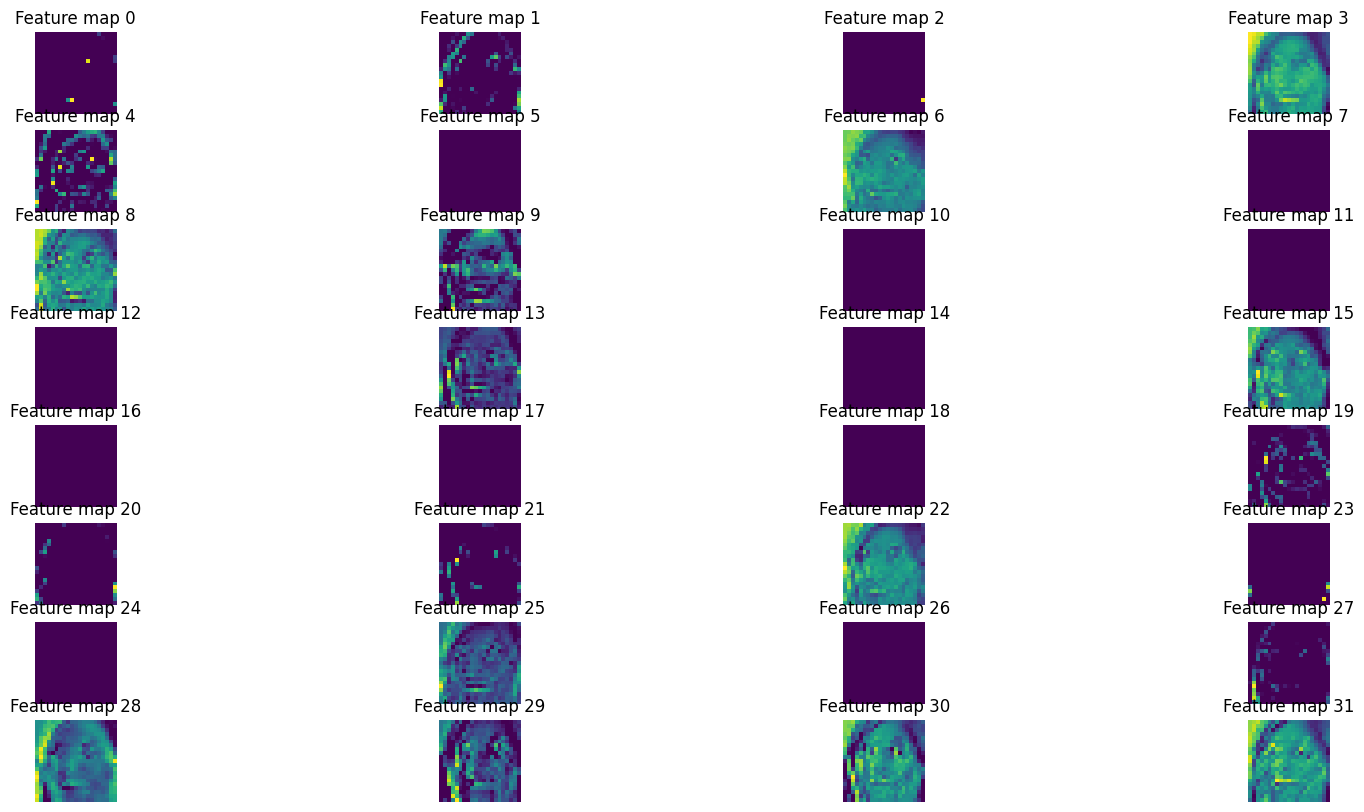

In [45]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    if i < first_layer_activation.shape[-1]:
        ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        ax.set_title(f'Feature map {i}')
        ax.axis('off')
plt.show()

### CNN

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [74]:
img_train = []
for i in range(len(X_train_sm)):
    img_train.append(X_train_sm[i].reshape(48, 48))
    img_train[i] = np.expand_dims(img_train[i], axis=-1)
    # img_train[i] = np.expand_dims(img_train[i], axis=0)
img_train = np.array(img_train)

In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    img_train, y_train_sm,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stop]
)


Epoch 1/50


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [71]:
img_train.shape[0]

AttributeError: 'list' object has no attribute 'shape'